# **\[SOLAR_A\]** Add Early Stopping

JiyunLim  
2023-08-26

## Import

In [30]:
# modules 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# pytorch geometric
from torch_geometric_temporal.signal import temporal_signal_split
import torch_geometric_temporal
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal


# torch
import torch
import torch.nn.functional as F

# from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.nn.recurrent import GConvLSTM
# from torch_geometric_temporal.nn.recurrent import GCLSTM
# from torch_geometric_temporal.nn.recurrent import LRGCN
# from torch_geometric_temporal.nn.recurrent import TGCN
# from torch_geometric_temporal.nn.recurrent import DCRNN


# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self, patience=1):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self.patience = patience # Early stopping patience
        self.best_loss = float('inf')
        self.early_stop_counter = 0
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio = self.train_ratio) ####
        self.len_test = self.test_dataset.snapshot_count 
        self.len_tr = self.train_dataset.snapshot_count

    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                self.h, self.c = None, None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            mean_loss = np.mean(losses_batch)
            self.losses.append(mean_loss)
            
            print(f'\repoch={self.epochs}\t loss={mean_loss}\n', end='', flush=True)
            
            if mean_loss < self.best_loss:
                self.best_loss = mean_loss
                self.early_stop_counter = 0
                self._savefigs()
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("Early stopping triggered")
                    return 
                
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
            #mplcyberpunk.add_glow_effects()  
        self.figs.append(fig)
        plt.close()
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 
    

def rslt_plot(y, yhat, t_, node_idx):
    with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(y[:t_,node_idx],label='real',lw=0.5)
            ax.plot(yhat[:t_,node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={lrnr.epochs}, node_idx={node_idx}',size=15)
            ax.legend()

In [31]:
class GConv_LSTM(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GConv_LSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

## Load Data

In [32]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [33]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## Learn

In [18]:
# step1: create lrnr object
lrnr = RGCN_Learner(patience = 1)
# step2: load data 
lrnr.lags = 24
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 4
lrnr.model = GConv_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=100/1000)
# step4: learn 
batch_size = 128
lrnr.get_batches(batch_size)
# for e in range(100): ##    
#     lrnr.learn()

In [19]:
lrnr.learn(100)

epoch=1  loss=0.5409723175689578207977295   
epoch=2  loss=0.233105783350765782901764        
epoch=3  loss=0.1515072123147547298482895   
epoch=4  loss=0.115741593297570942623558        
epoch=5  loss=0.1084882370196282997380066   
epoch=6  loss=0.1029932810924947316339874   
epoch=7  loss=0.0972931901924312101810455   
epoch=8  loss=0.0945442719385027969766617   
epoch=9  loss=0.0925112995319068493907166   
epoch=10     loss=0.093668440822511913192749    
Early stopping triggered

In [20]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [21]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))

classic(mse) 0.0853

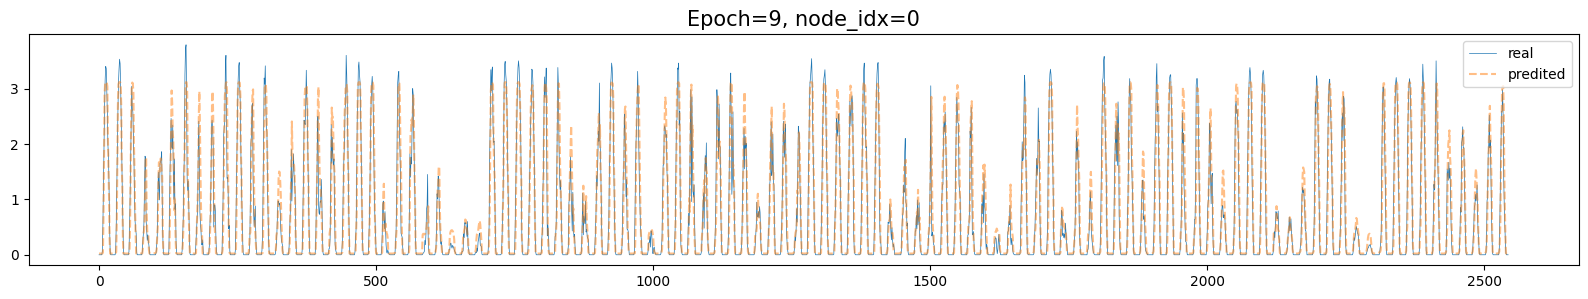

In [24]:
lrnr.figs[-1]

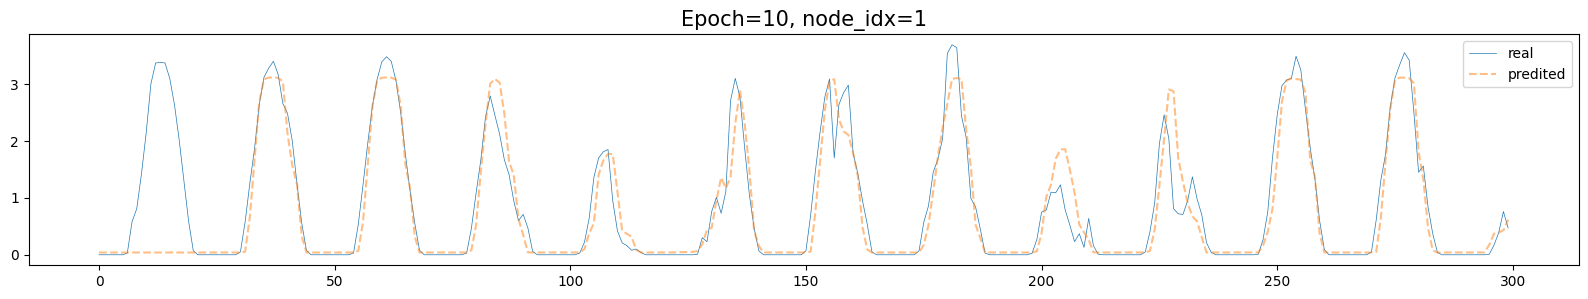

In [25]:
rslt_plot(y, yhat, 300, 1)

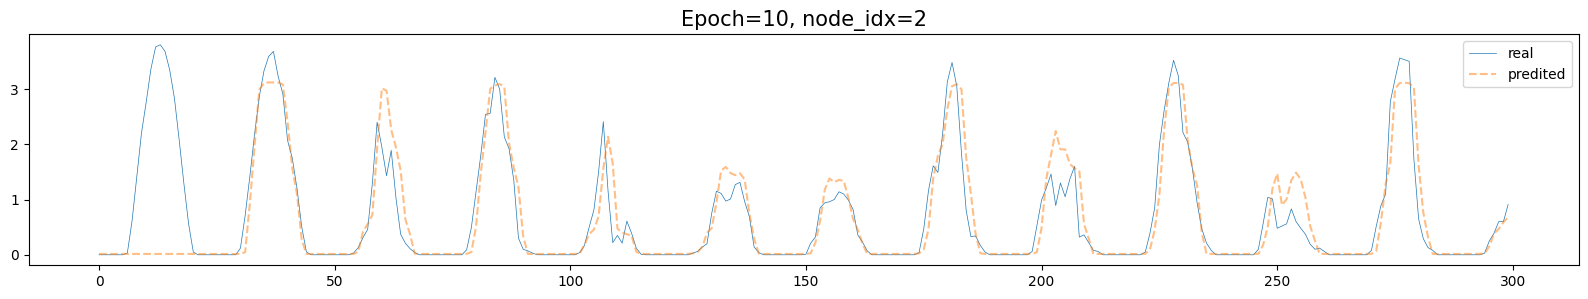

In [26]:
rslt_plot(y, yhat, 300, 2)